<a href="https://colab.research.google.com/github/finesketch/deep_learning/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/Course4_Part2_Lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [13]:
i = 0
for x, y in dataset:
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  i += 1
  if i == 1:
    break

x =  [[40.778324   31.413609   33.544636   36.22143    38.910835   31.098982
  32.022236   26.868631   25.863333   35.345516   37.49725    29.783985
  34.584694   30.793396   25.17319    29.614908   34.903008   26.434551
  33.833897   12.305289  ]
 [35.969654   21.868246   38.740505   18.333178   27.353228   31.072536
  29.55496    25.05581    27.14825    25.743662   25.281895   32.497025
  30.054634   24.825788   32.809357   29.869114   32.418423   31.52398
  24.252817   25.619074  ]
 [57.16999    46.721287   47.04894    43.50735    41.55169    49.94979
  41.51532    46.151627   43.403996   48.186077   47.458817   50.977943
  43.240307   44.441574   40.89809    43.571808   47.681534   49.58213
  41.188908   50.150696  ]
 [47.04894    43.50735    41.55169    49.94979    41.51532    46.151627
  43.403996   48.186077   47.458817   50.977943   43.240307   44.441574
  40.89809    43.571808   47.681534   49.58213    41.188908   50.150696
  52.584183   47.876865  ]
 [61.65801    59.0514     

In [15]:
dense_layer = tf.keras.layers.Dense(1, input_shape=[window_size])

model = tf.keras.models.Sequential([dense_layer])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

history = model.fit(dataset, epochs=100, verbose=0)

print('Layer weights {}'.format(dense_layer.get_weights()))


Layer weights [array([[-0.00656633],
       [-0.00423081],
       [ 0.0084551 ],
       [-0.06674844],
       [ 0.02245001],
       [ 0.05565074],
       [ 0.04248081],
       [-0.00955439],
       [-0.05914737],
       [-0.03507196],
       [ 0.02054515],
       [ 0.06161061],
       [-0.09752776],
       [ 0.04855958],
       [ 0.05863822],
       [ 0.07104753],
       [-0.03465544],
       [ 0.13681573],
       [ 0.36439514],
       [ 0.40196642]], dtype=float32), array([0.0164445], dtype=float32)]


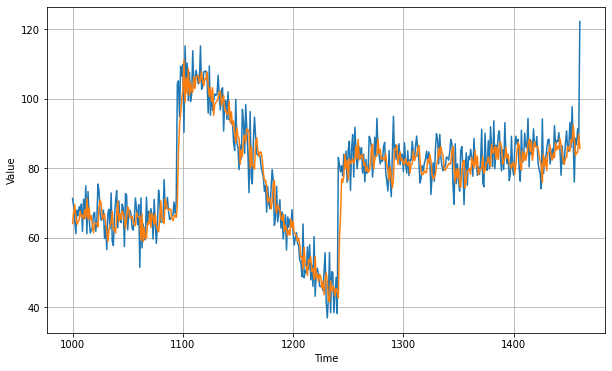

In [8]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9771905